<a href="https://colab.research.google.com/github/Anik-1802021/ML-Autoencoder-denoise-custom-dataset/blob/main/Denoise_Autoencoder_custom_dataset_v_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
29/29 [==============================] - 377s 13s/step - loss: 0.5676 - val_loss: 0.4508
Epoch 2/10
29/29 [==============================] - 362s 13s/step - loss: 0.4235 - val_loss: 0.3800
Epoch 3/10
29/29 [==============================] - 358s 12s/step - loss: 0.3946 - val_loss: 0.3730
Epoch 4/10
29/29 [==============================] - 353s 12s/step - loss: 0.3864 - val_loss: 0.3681
Epoch 5/10
29/29 [==============================] - 353s 12s/step - loss: 0.3818 - val_loss: 0.3653
Epoch 6/10
29/29 [==============================] - 354s 12s/step - loss: 0.3794 - val_loss: 0.3635
Epoch 7/10
29/29 [==============================] - 356s 12s/step - loss: 0.3779 - val_loss: 0.3623
Epoch 8/10
29/29 [==============================] - 357s 12s/step - loss: 0.3766 - val_loss: 0.3612
Epoch 9/10
29/29 [==============================] - 357s 12s/step - loss: 0.3754 - val_loss: 0.3601
Epoch 10/10
29/29 [==============================] - 356s 12s/step - loss: 0.3742 - val_loss: 0.3591

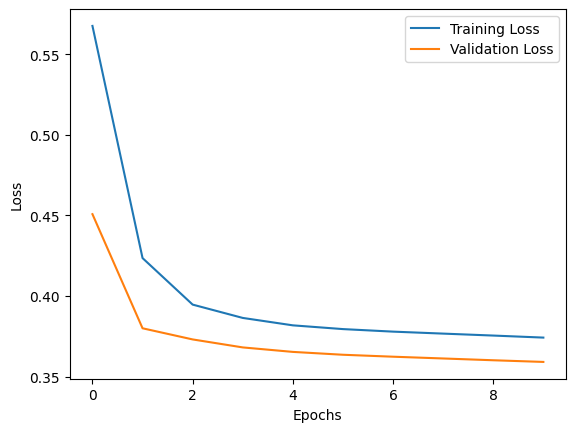

4/4 [==============================] - 25s 7s/step


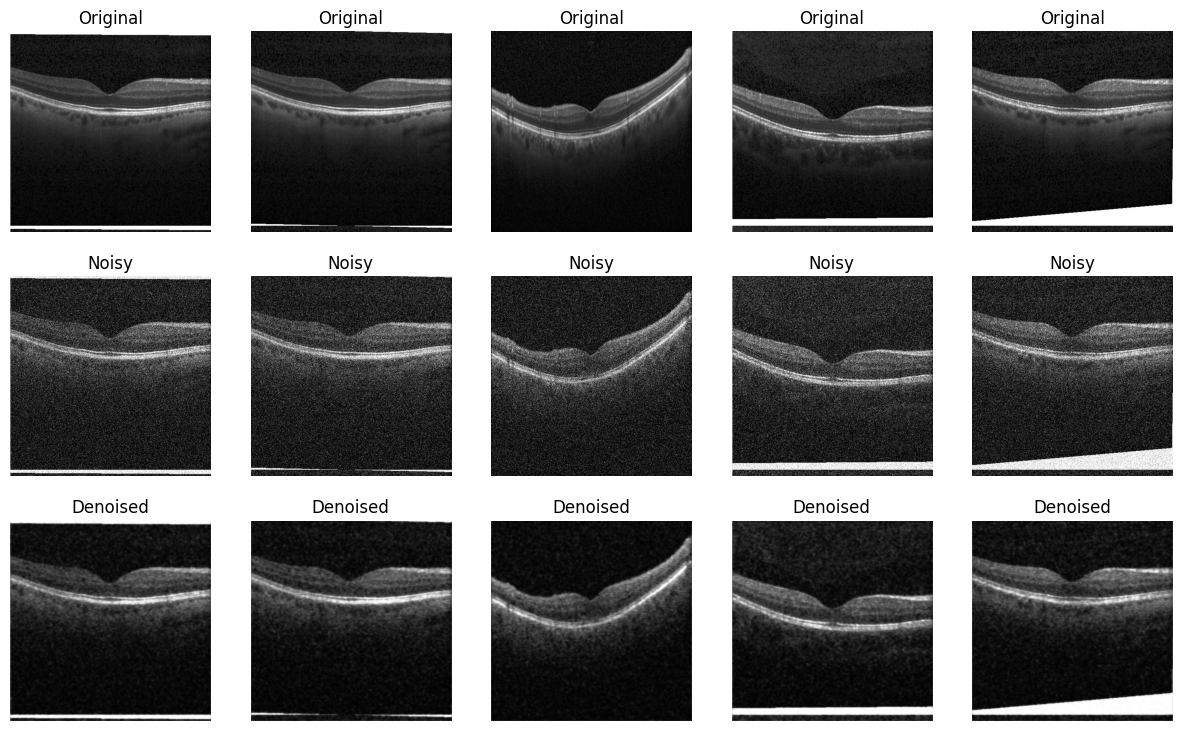

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

# Function to load and preprocess images
def load_images_from_folder(folder, image_size=(512, 512)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = plt.imread(img_path, format='grayscale')  # Load image in grayscale
            img = img / 255.0  # Normalize pixel values to [0, 1]
            img = img.astype('float32')
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            img = np.resize(img, image_size)  # Resize image to specified dimensions
            images.append(img)
    images = np.array(images)
    return images

# Load images from the specified dataset folder
dataset_folder = '/content/drive/MyDrive/Thesis/Swin Transformer /custom_dataset/train/NORMAL'
image_size = (512, 512)
images = load_images_from_folder(dataset_folder, image_size)

# Split data into training and test sets
x_train = images[:int(0.8 * len(images))]
x_test = images[int(0.8 * len(images)):]

# Add noise to the data
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Define the denoising autoencoder model
def denoising_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
    # Decoder
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    up1 = UpSampling2D((2, 2))(conv2)
    # Output
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up1)
    model = Model(inputs, outputs)
    return model

# Create and compile the denoising autoencoder model
input_shape = (image_size[0], image_size[1], 1)
denoise_model = denoising_autoencoder(input_shape)
denoise_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history = denoise_model.fit(x_train_noisy, x_train, epochs=10, batch_size=16, validation_data=(x_test_noisy, x_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on test data
denoised_images = denoise_model.predict(x_test_noisy)

# Display original, noisy, and denoised images
n = 5
plt.figure(figsize=(15, 9))
for i in range(n):
    # Original Image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(image_size), cmap='gray')
    ax.set_title('Original')
    ax.axis('off')
    # Noisy Image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(image_size), cmap='gray')
    ax.set_title('Noisy')
    ax.axis('off')
    # Denoised Image
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(image_size), cmap='gray')
    ax.set_title('Denoised')
    ax.axis('off')
plt.show()
